In [1]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
from collections import Counter

##### Load dataset

In [2]:
# Import data
iris = load_iris()
X = iris.data
y = iris.target

In [3]:
X[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [4]:
y[:5]

array([0, 0, 0, 0, 0])

##### #Split the data into training and test sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

In [6]:
#Convert X_train and X_test to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [7]:
#Dataset
class IrisData(Dataset):
    def __init__(self, X_train, y_train):
        super().__init__()
        self.X = torch.from_numpy(X_train)
        self.y = torch.from_numpy(y_train)
        self.y = self.y.type(torch.LongTensor)
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.len
    
#DataLoader
iris_data = IrisData(X_train=X_train, y_train=y_train)
train_loader = DataLoader(dataset=iris_data, batch_size=32)

#Check for dimension
print('Shape: {}, y shape: {}'.format(iris_data.X.shape, iris_data.y.shape))

Shape: torch.Size([120, 4]), y shape: torch.Size([120])


In [8]:
#Define Custom MultiClass
class MultiClassNet(nn.Module):
    def __init__(self,  NUM_FEATURES, NUM_CLASSES, HIDDEN_FEATURES):
        super().__init__()
        self.linear1 = nn.Linear(NUM_FEATURES, HIDDEN_FEATURES)
        self.linear2 = nn.Linear(HIDDEN_FEATURES, NUM_CLASSES)
        self.log_softmax = nn.LogSoftmax(dim=1)

    #Create forward function
    def forward(self, x):
        x = self.linear1(x)
        x = torch.sigmoid(x)
        x = self.linear2(x)
        x = self.log_softmax(x)
        return x
    
#Hyperparameter
NUM_FEATURES = iris_data.X.shape[1]
HIDDEN = 6
NUM_CLASSES = len(iris_data.y.unique())
print(NUM_CLASSES)

3


In [9]:
#Create model instance
model = MultiClassNet(NUM_FEATURES=NUM_FEATURES, NUM_CLASSES=NUM_CLASSES, HIDDEN_FEATURES=HIDDEN)

#Loss function
criterion = nn.CrossEntropyLoss()

#Optimizer
lr = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

<Axes: >

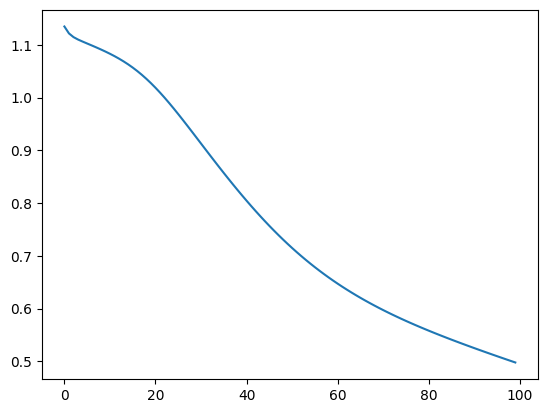

In [10]:
#Training Loop
NUM_EPOCHS = 100
losses = []

for epoch in range(NUM_EPOCHS):
    for X, y in train_loader:

        # initialize gradients
        optimizer.zero_grad()

        #Forward pass
        y_pred_log = model(X)

        #Calculate losses
        loss = criterion(y_pred_log, y)

        #Calculate gradient
        loss.backward()

        #Update parameters
        optimizer.step()

    losses.append(float(loss.data.detach().numpy()))
    #print(losses)

#Plot losses against epochs
sns.lineplot(x= range(len(losses)), y = losses)

Model Evaluation

In [11]:
#Convert the test xet to torch
X_test_torch = torch.from_numpy(X_test)
X_test[:2], X_test_torch[:2]

(array([[6. , 2.2, 5. , 1.5],
        [6.4, 2.8, 5.6, 2.1]], dtype=float32),
 tensor([[6.0000, 2.2000, 5.0000, 1.5000],
         [6.4000, 2.8000, 5.6000, 2.1000]]))

In [12]:
with torch.no_grad():
    y_test_log = model(X_test_torch)
    y_test_pred = torch.max(y_test_log, 1)

y_test_log[:3], 

(tensor([[-3.4292, -0.9122, -0.5693],
         [-3.8498, -1.0173, -0.4827],
         [-3.8168, -0.9999, -0.4942]]),)

In [13]:
y_test_pred.indices

tensor([2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 0, 0, 1, 0, 2, 0, 2, 0, 0, 1, 2, 0, 0,
        1, 1, 1, 1, 0, 1])

In [14]:
acc = accuracy_score(y_test, y_test_pred.indices)
print('Accuracy Score: {:.2f}'.format(acc))

Accuracy Score: 0.97


Naive Classifier

In [15]:
Counter(y_test).most_common()

[(np.int64(1), 11), (np.int64(2), 10), (np.int64(0), 9)]

In [16]:
Counter(y_test).most_common()[0]

(np.int64(1), 11)

In [17]:
most_common_count = Counter(y_test).most_common()[0][1]

In [18]:
print('Naive Classifier Accuracy score: {:.2f}'.format(most_common_count/len(y_test)))

Naive Classifier Accuracy score: 0.37
